In [22]:
import sqlite3 as lite
import datetime as dt
import sys
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# %load 'helpers.py'
# helper functions

import adafruit_dht
import board
import time
import psutil
import sqlite3 as lite
import sys
import os

def init_dht(model=22):
    model = int(model)
    print(model)
    flag = True
    while flag:
        try:
            print("attempting to initialize device...")
            if model == int(22):
                print("DHT22...")
                dhtDevice = adafruit_dht.DHT22(board.D4)
            elif model == int(11):
                print("DHT11...")
                dhtDevice = adafruit_dht.DHT11(board.D4)
            else:
                print("incorrect DHT model number--enter '11' or '22'")
                return None
            dhtDevice.temperature
            print("successfully initialized DHT" + str(model))

        except RuntimeError as error:
            print(error.args[0])
            print("failed to initialize, cleaning up libgpio processes...")
            for p in psutil.process_iter():
                if p.name()[:8] == 'libgpiod':
                    print("killing {} (pid: {})".format(p.name(), p.pid))
                    p.kill()
            time.sleep(5)
            continue
        flag = False
    return dhtDevice


def read_dht(dhtDevice, deg='F'):
    while True:
        try:
            t = dhtDevice.temperature
            h = dhtDevice.humidity
            if deg == 'F':
                t = t * (9 / 5) + 32
            return (t, h)
        except RuntimeError as error:
            print(error.args[0])
            time.sleep(2)


def create_table(location, debug=False):
    # Create DHT_data table if it doesn't exist already
    if not os.path.isdir(location):
        assert False, "cannot create table, directory given (" + location + ") does not exist!"
    con = lite.connect(os.path.join(location, 'sensorsData.db'))
    with con:
        cur = con.cursor()
        #if table 'DHT_data' exists:
        try:
            cur.execute("CREATE TABLE DHT_data(timestamp DATETIME, temp NUMERIC, hum NUMERIC)")
            if debug:
                print("Created DHT_data table")
        except:
            if debug:
                print("DHT_data table already exists")
    return con


def add_entry(db, timestamp, temp, hum, debug=False):
    # Add a temp/humidity reading to the database
    with db as con:
        cur = con.cursor()
        if debug:
            print("Adding DHT reading to DHT_data table: ", timestamp, temp, hum)
        cur.execute("INSERT INTO DHT_data VALUES((?), (?), (?))", (timestamp, temp, hum))

In [17]:
def convert_db_ts(timestr):
    return dt.datetime.strptime(timestr, '%Y-%m-%d %H:%M:%S.%f')

def convert_log_ts(timestr):
    return dt.datetime.strptime(timestr, '%Y-%m-%d-%H:%M:%S')

def read_log_entries(logfile):
    with open(logfile, "r") as f:
        lines = f.readlines()
    times = []
    temps = []
    hums = []
    for idx, val in enumerate(lines):
        try:
            ts = convert_log_ts(val.split(',')[0])
            temp = float(val.split(',')[1][7:][:-2])
            hum = float(val.split(',')[2][10:][:-2])
            times.append(ts)
            temps.append(temp)
            hums.append(hum)
        except:
            lines.pop(idx)
    df =  pd.DataFrame([times, temps, hums]).transpose()
    df.columns = ['timestamp', 'temp', 'hum']
    return df

In [5]:
db_dir = '/home/pi/repos/humidity_logging/db'
db = create_table(db_dir, debug=True)

DHT_data table already exists


In [4]:
DHT = init_dht(22)

22
attempting to initialize device...
DHT22...
successfully initialized DHT22


In [5]:
t, h = read_dht(DHT)
now = dt.datetime.now()
add_entry(db, now, t, h, debug=True)

Adding DHT reading to DHT_data table:  2020-12-13 12:23:54.209799 66.56 59.6


In [6]:
help(db)

Help on Connection object:

class Connection(builtins.object)
 |  SQLite database connection object.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __enter__(...)
 |      For context manager. Non-standard.
 |  
 |  __exit__(...)
 |      For context manager. Non-standard.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  backup(...)
 |      Makes a backup of the database. Non-standard.
 |  
 |  close(...)
 |      Closes the connection.
 |  
 |  commit(...)
 |      Commit the current transaction.
 |  
 |  create_aggregate(...)
 |      Creates a new aggregate. Non-standard.
 |  
 |  create_collation(...)
 |      Creates a collation function. Non-standard.
 |  
 |  create_function(...)
 |      Creates a new function. Non-standard.
 |  
 |  cursor(...)
 |      Return a cursor for the connection.
 |  
 |  enable_load_extension(...)
 |      Enable dyn

In [20]:
it = db.iterdump()

for i in it:
    print(i)

BEGIN TRANSACTION;
CREATE TABLE DHT_data(timestamp DATETIME, temp NUMERIC, hum NUMERIC);
INSERT INTO "DHT_data" VALUES('2020-12-11 23:42:34.996891',62.96,61.9);
INSERT INTO "DHT_data" VALUES('2020-12-11 23:43:35.402283',62.96,62);
INSERT INTO "DHT_data" VALUES('2020-12-13 10:50:16.520659',66.2,61.1);
INSERT INTO "DHT_data" VALUES('2020-12-13 10:50:54.251205',66.2,60.9);
INSERT INTO "DHT_data" VALUES('2020-12-13 10:51:57.014126',66.2,60.8);
INSERT INTO "DHT_data" VALUES('2020-12-13 10:57:31.549155',66.2,60.8);
INSERT INTO "DHT_data" VALUES('2020-12-13 10:58:38.935832',66.2,60.6);
INSERT INTO "DHT_data" VALUES('2020-12-13 11:00:59.412823',66.2,60.6);
INSERT INTO "DHT_data" VALUES('2020-12-13 11:02:57.964563',66.2,60.9);
COMMIT;


In [6]:
df = pd.read_sql_query("SELECT * from DHT_data", db)

In [7]:
df

,timestamp,temp,hum
0,2020-12-12 00:05:46.749272,62.78,61.1
1,2020-12-12 00:07:04.279382,62.78,62.2
2,2020-12-12 00:08:04.620589,62.60,62.1
3,2020-12-12 00:09:11.970003,62.60,62.1
4,2020-12-12 00:10:14.664345,62.60,62.2
...,...,...,...
2001,2020-12-13 15:26:29.336198,67.46,57.5
2002,2020-12-13 15:31:29.779100,67.46,57.5
2003,2020-12-13 15:36:32.412486,67.46,57.3
2004,2020-12-13 15:41:35.067839,67.46,56.4


In [18]:
df_log = pd.DataFrame()
for log in os.listdir('./logs'):
    print("reading " + log)
    new = read_log_entries(os.path.join('./logs', log))
    df_log = pd.concat([df_log, new], axis = 0)

reading DHT-2020-11-18.log
reading DHT-2020-11-25.log
reading DHT-2020-11-13.log
reading DHT-2020-12-02.log
reading DHT-2020-11-03.log
reading DHT-2020-11-15.log
reading DHT-2020-11-29.log
reading DHT-2020-12-06.log
reading DHT-2020-11-08.log
reading DHT-2020-11-05.log
reading DHT-2020-11-02.log
reading DHT-2020-10-19.log
reading DHT-2020-12-07.log
reading DHT-2020-12-01.log
reading DHT-2020-11-22.log
reading DHT-2020-11-30.log
reading DHT-2020-10-28.log
reading DHT-2020-10-23.log
reading DHT-2020-10-22.log
reading DHT-2020-11-07.log
reading DHT-2020-11-16.log
reading DHT-2020-11-24.log
reading DHT-2020-11-21.log
reading DHT-2020-12-04.log
reading DHT-2020-11-27.log
reading DHT-2020-11-01.log
reading DHT-2020-12-03.log
reading DHT-2020-11-14.log
reading DHT-2020-11-12.log
reading DHT-2020-11-20.log
reading DHT-2020-11-06.log
reading DHT-2020-10-31.log
reading DHT-2020-12-12.log
reading DHT-2020-12-10.log
reading DHT-2020-11-11.log
reading DHT-2020-11-23.log
reading DHT-2020-11-09.log
r

In [19]:
df_log

,timestamp,temp,hum
0,2020-11-18 00:00:39,73.4,39
1,2020-11-18 00:01:39,73.4,39
2,2020-11-18 00:04:40,73.4,39
3,2020-11-18 00:09:57,73.4,39
4,2020-11-18 00:12:58,73.4,39
...,...,...,...
335,2020-10-29 18:30:41,84.2,53
336,2020-10-29 18:32:42,84.2,52
337,2020-10-29 18:33:42,84.2,52
338,2020-10-29 18:34:43,84.2,52


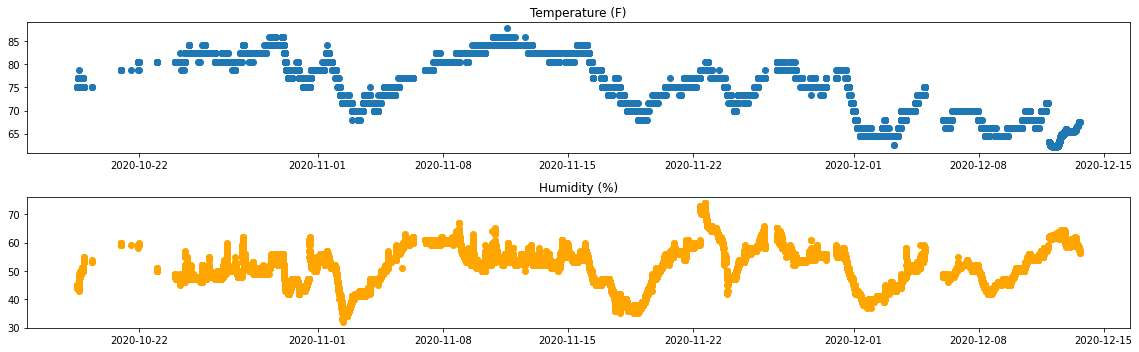

In [23]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 5))
ax[0].scatter(df_log["timestamp"], df_log["temp"], label="Temp (F)")
ax[0].set_title("Temperature (F)")
ax[1].scatter(df_log["timestamp"], df_log["hum"], label="Humidity (%)", color='orange')
ax[1].set_title("Humidity (%)")
fig.tight_layout()